In [1]:
"""Import Statements"""
import openmc
import numpy as np
import matplotlib.pyplot as plt

In [10]:
"""Define the geometry of the 'Fuel' Assembly"""

# Measurements from Schnitzler et al. 2012
propellant_channel_diameter = 0.2565
propellant_channel_inner_cladding_thickness = 0.01
propellant_channel_pitch = 0.4089
assembly_cladding_thickness = 0.005
assembly_edge_length = 3*propellant_channel_pitch+2*(assembly_cladding_thickness*np.tan(30*np.pi/180))

# OpenMC Geometry
borehole = openmc.ZCylinder(r=propellant_channel_diameter/2)
borehole_inner_cladding = openmc.ZCylinder(r=propellant_channel_diameter/2 \
                                                    -propellant_channel_inner_cladding_thickness)
fuel_assembly = openmc.model.HexagonalPrism(orientation='x', edge_length = 3*propellant_channel_pitch)
fuel_assembly_cladding = openmc.model.HexagonalPrism(orientation='x', edge_length=assembly_edge_length)

# OpenMC Cells and Universes
propellant_channel_interior = openmc.Cell(region = -borehole_inner_cladding)
propellant_channel_cladding = openmc.Cell(region = -borehole)
propellant_channel_outer_fuel = openmc.Cell(region = +borehole)
propellant_channel = openmc.Universe(cells = (propellant_channel_interior, propellant_channel_cladding, \
                                             propellant_channel_outer_fuel))
fuel_assembly_cell = openmc.Cell(region=-fuel_assembly)
fuel_assembly_cladding_cell = openmc.Cell(region=+fuel_assembly & -fuel_assembly_cladding) 

outer_lattice_universe = openmc.Universe(cells=[fuel_assembly_cell])

# OpenMC Fuel Lattice
fuel_lattice = openmc.HexLattice()
fuel_lattice.orientation="x"
fuel_lattice.outer=outer_lattice_universe
fuel_lattice.pitch = (propellant_channel_pitch,)
fuel_lattice.universes = [[propellant_channel]*12, [propellant_channel]*6, [propellant_channel]]
fuel_lattice.center=(0.0, 0.0)

# Full Fuel Asembly
fuel_assembly_lattice_cell = openmc.Cell(region = -fuel_assembly, fill = fuel_lattice)
fuel_assembly_universe = openmc.Universe(cells=[fuel_assembly_cladding_cell,\
                                                fuel_assembly_lattice_cell])

geometry = openmc.Geometry(root=fuel_assembly_universe)
geometry.export_to_xml()
# blank files to get the plotter working
settings = openmc.Settings()
settings.export_to_xml()

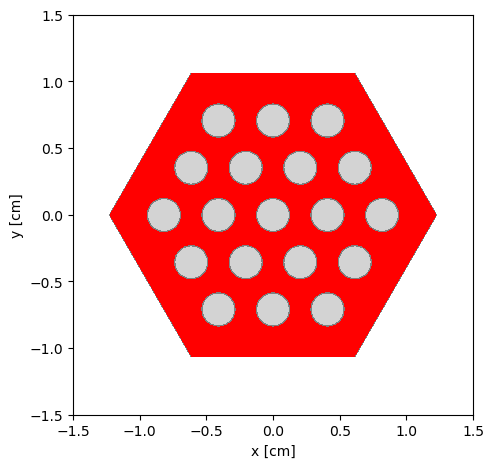

In [3]:
"""Plot Fuel Assembly Geometry"""
fuel_colors_dict = {propellant_channel_interior:"lightgray", propellant_channel_cladding:"gray",\
                    propellant_channel_outer_fuel:"red", fuel_assembly_cell:"red",\
                    fuel_assembly_cladding_cell:"gray"}
fuel_assembly_universe.plot(pixels =(400,400), width = (3,3), colors=fuel_colors_dict)
plt.show()

In [4]:
"""Define the geometry of the 'Tie Tube' Assembly"""

# Measurements from Schnitzler et al. 2007 (CURRENT NUMBERS ARE PLACEHOLDERS WHILE I WAIT FOR A COPY)
inner_gap_outer_radius = 0.3
inner_tie_tube_outer_radius = 0.35
moderator_outer_radius = 0.70
outer_gap_outer_radius = 0.78
outer_tie_tube_outer_radius = 0.81
insulator_outer_radius = 0.9

# OpenMC Geometry
inner_gap = openmc.ZCylinder(r=inner_gap_outer_radius)
inner_tie_tube = openmc.ZCylinder(r=inner_tie_tube_outer_radius)
moderator_tube = openmc.ZCylinder(r=moderator_outer_radius)
outer_gap = openmc.ZCylinder(r=outer_gap_outer_radius)
outer_tie_tube = openmc.ZCylinder(r=outer_tie_tube_outer_radius)
insulator = openmc.ZCylinder(r=insulator_outer_radius)
tie_tube_assembly = openmc.model.HexagonalPrism(orientation='x', edge_length = 3*propellant_channel_pitch)
tie_tube_assembly_cladding = openmc.model.HexagonalPrism(orientation='x', edge_length=assembly_edge_length)

# OpenMC Cells and Universes
inner_gap_cell = openmc.Cell(region= -inner_gap)
inner_tie_tube_cell = openmc.Cell(region= +inner_gap & - inner_tie_tube)
moderator_tube_cell = openmc.Cell(region= +inner_tie_tube & -moderator_tube)
outer_gap_cell = openmc.Cell(region= +moderator_tube & -outer_gap)
outer_tie_tube_cell = openmc.Cell(region= +outer_gap & -outer_tie_tube)
insulator_cell = openmc.Cell(region= +outer_tie_tube & -insulator)
tie_tube_assembly_cell = openmc.Cell(region=-tie_tube_assembly)
tie_tube_assembly_cladding_cell = openmc.Cell(region=+tie_tube_assembly & -tie_tube_assembly_cladding) 

# Full Tie Tube Assembly
tie_tube_assembly_universe = openmc.Universe(cells=[inner_gap_cell, inner_tie_tube_cell, moderator_tube_cell,\
                                                    outer_gap_cell, outer_tie_tube_cell, insulator_cell, \
                                                    tie_tube_assembly_cell, tie_tube_assembly_cladding_cell])


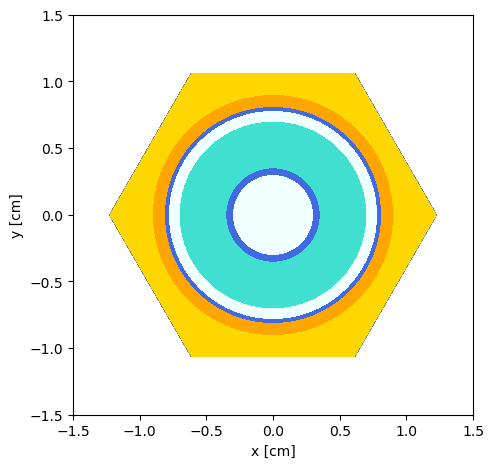

In [5]:
"""Plot Tie Tube Assembly Geometry"""
tie_tube_cell_colors_dict = {inner_gap_cell:"azure",inner_tie_tube_cell:"royalblue",moderator_tube_cell:"turquoise",\
                    outer_gap_cell:"azure",outer_tie_tube_cell:"royalblue",insulator_cell:"orange",\
                    tie_tube_assembly_cell:"gold", tie_tube_assembly_cladding_cell:"gray"}
tie_tube_assembly_universe.plot(pixels =(400,400), width = (3,3), colors = tie_tube_cell_colors_dict)
plt.show()

In [6]:
"""Create Larger (3 Ring) Core Geometry Structures"""

# Measurements from Schnitzler et al. 2012
assembly_pitch = 1.905

# Sparse Configuration
three_ring_sparse_configuration = openmc.HexLattice()
three_ring_sparse_configuration.orientation = "y"
three_ring_sparse_configuration.pitch = (assembly_pitch,)
three_ring_sparse_configuration.universes = [[tie_tube_assembly_universe, fuel_assembly_universe]*6, \
                                             [fuel_assembly_universe]*6, [tie_tube_assembly_universe]]
three_ring_sparse_configuration.center=(0.0,0.0)
three_ring_sparse_configuration_cell = openmc.Cell(fill=three_ring_sparse_configuration)
three_ring_sparse_configuration_universe = openmc.Universe(cells=[three_ring_sparse_configuration_cell])

# SNRE Configuration
three_ring_SNRE_configuration = openmc.HexLattice()
three_ring_SNRE_configuration.orientation = "y"
three_ring_SNRE_configuration.pitch = (assembly_pitch,)
three_ring_SNRE_configuration.universes = [[fuel_assembly_universe, tie_tube_assembly_universe]*6, \
                                             [fuel_assembly_universe]*6, [tie_tube_assembly_universe]]
three_ring_SNRE_configuration.center=(0.0,0.0)
three_ring_SNRE_configuration_cell = openmc.Cell(fill=three_ring_SNRE_configuration)
three_ring_SNRE_configuration_universe = openmc.Universe(cells=[three_ring_SNRE_configuration_cell])

# Dense Configuration
three_ring_dense_configuration = openmc.HexLattice()
three_ring_dense_configuration.orientation = "y"
three_ring_dense_configuration.pitch = (assembly_pitch,)
three_ring_dense_configuration.universes = [[tie_tube_assembly_universe, tie_tube_assembly_universe,\
                                             tie_tube_assembly_universe, fuel_assembly_universe,\
                                             tie_tube_assembly_universe, fuel_assembly_universe,\
                                             tie_tube_assembly_universe, tie_tube_assembly_universe,\
                                             tie_tube_assembly_universe, fuel_assembly_universe,\
                                             tie_tube_assembly_universe, fuel_assembly_universe], \
                                            [fuel_assembly_universe, fuel_assembly_universe,\
                                             tie_tube_assembly_universe, fuel_assembly_universe,\
                                             fuel_assembly_universe, tie_tube_assembly_universe], \
                                            [tie_tube_assembly_universe]]
three_ring_dense_configuration.center=(0.0,0.0)
three_ring_dense_configuration_cell = openmc.Cell(fill=three_ring_dense_configuration)
three_ring_dense_configuration_universe = openmc.Universe(cells=[three_ring_dense_configuration_cell])

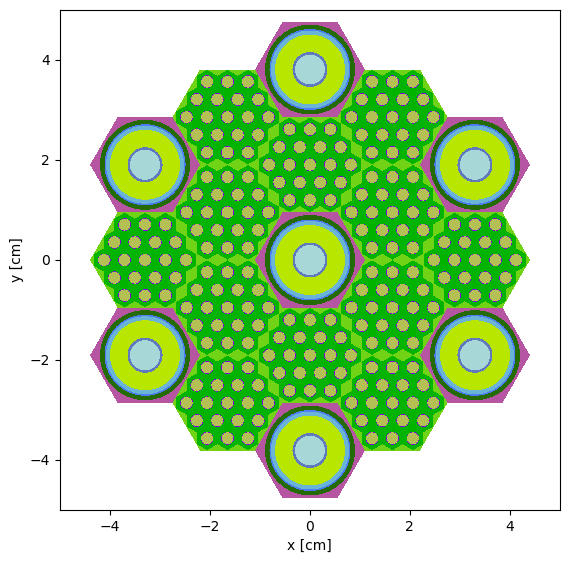

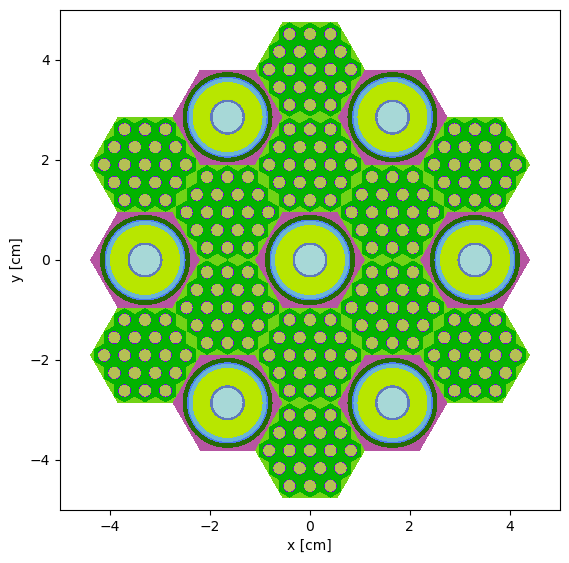

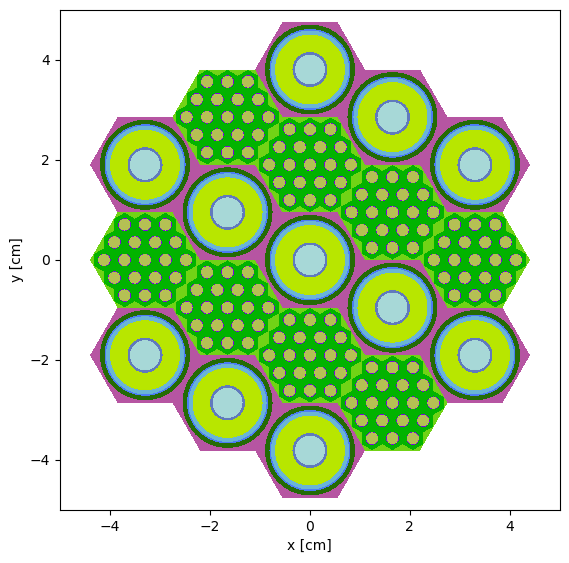

In [7]:
"""Plot the Larger Core Geometry Structures"""
three_ring_sparse_configuration_universe.plot(pixels = (500,500))
plt.show()

three_ring_SNRE_configuration_universe.plot(pixels = (500,500))
plt.show()

three_ring_dense_configuration_universe.plot(pixels = (500,500))
plt.show()